<a href="https://colab.research.google.com/github/5levic/Fastai-course/blob/main/Chapter_2_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will create a flower classification algorithm

This data set contains images of flowers from 102 different species. We will build a simple model which will allow to claddify theses images.

### 1. First we import all necessary tools

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *
!pip install opendatasets
import opendatasets as od
import zipfile
import json
from pathlib import Path

     |████████████████████████████████| 720 kB 3.2 MB/s 
     |████████████████████████████████| 189 kB 55.0 MB/s 
     |████████████████████████████████| 1.2 MB 37.7 MB/s 
     |████████████████████████████████| 48 kB 3.5 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 51 kB 263 kB/s 
     |████████████████████████████████| 561 kB 51.0 MB/s 
     |████████████████████████████████| 130 kB 46.2 MB/s 


### 2. Downloading and unziping the flower dataset

In [4]:
od.download("https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip")

311443456it [00:04, 71608263.09it/s]                               


In [5]:
!mkdir flowers
with zipfile.ZipFile('/content/flower_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flowers')

Checking if all images are valid - all can be opened:

In [6]:
failed = verify_images('/content/flowers/flower_data')

### 2. Creating a Fastai model

First we will creat a function which generates the label for each image.

In [7]:
def label_func(x):
  with open('/content/drive/MyDrive/Colab Notebooks/cat_to_name.json') as raw_file:
    json_str = raw_file.read()
    dict_label = json.loads(json_str)
  return dict_label[str(Path(x).parent.name)]

Secondly we will creat a DataLoader object that will provide batches of training and validation images a few items at a time (64) to the GPU. 

In [9]:
train_flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=label_func,
    item_tfms=Resize(128)
)

dls = train_flowers.dataloaders('/content/flowers/flower_data')


We can take a look at a few images in the validation dataset.

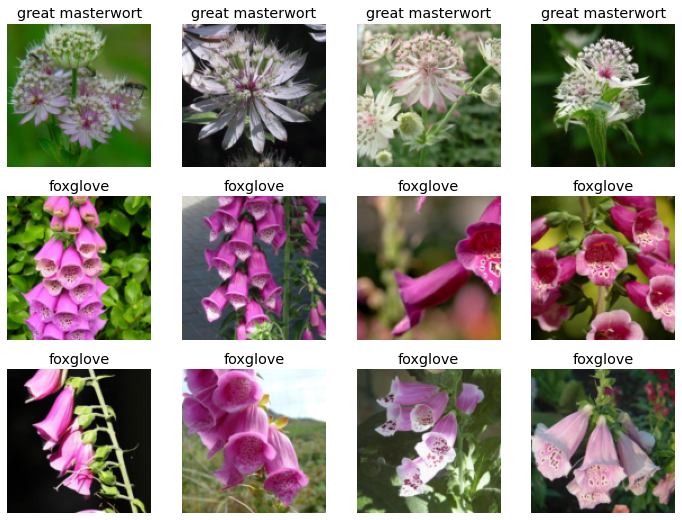

In [10]:
dls.valid.show_batch(max_n=12, nrows=3)

### 3.1 Training the first model

We will firs use the resnet18 architecture with basic settings of DataBlock.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.310173,1.159525,0.305623,07:59


epoch,train_loss,valid_loss,error_rate,time


### 3.2 Second model - DataBlock parameters adjustment

In [ ]:
train_flowers_2 = train_flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls_2 = train_flowers_2.dataloaders('/content/flowers/flower_data')
learn_2 = cnn_learner(dls_2, resnet18, metrics=error_rate)
learn_2.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,error_rate,time
0,2.907370,0.710203,0.166259,01:33


epoch,train_loss,valid_loss,error_rate,time
0,0.757677,0.291798,0.069682,01:56
1,0.425049,0.235197,0.056235,01:55


### 3.3 Third model - architecture adjustment

In [ ]:
learn_3 = cnn_learner(dls_2, resnet34, metrics=error_rate)
learn_3.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.938035,0.672177,0.173594,02:13


epoch,train_loss,valid_loss,error_rate,time
0,0.706831,0.263643,0.073350,03:07
1,0.348606,0.173547,0.046455,03:07


### 3.4 Second model with 4 additional epochs

In [ ]:
learn_2.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.305029,0.249341,0.068460,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.242974,0.192222,0.047677,01:55
1,0.192429,0.182058,0.042787,01:55
2,0.126087,0.162145,0.039120,01:55
3,0.081092,0.155453,0.040342,01:54


### 3.5  Third model with 4 additional epochs

In [ ]:
learn_3.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.238006,0.180990,0.047677,02:14


epoch,train_loss,valid_loss,error_rate,time
0,0.185948,0.189497,0.050122,03:07
1,0.163912,0.129783,0.029340,03:07
2,0.104363,0.112292,0.023227,03:07
3,0.060564,0.106264,0.025672,03:07


### 3.6 Fourth model - xresnet50 with 10 epochs

In [ ]:
learn_4 = cnn_learner(dls_2, xresnet50, metrics=error_rate)
learn_4.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.473444,2.638885,0.596577,03:03


epoch,train_loss,valid_loss,error_rate,time
0,2.078919,1.864171,0.453545,04:14
1,1.805401,1.542788,0.364303,04:14
2,1.490093,1.378081,0.344743,04:14
3,1.199127,1.102503,0.271394,04:14
4,0.980136,0.997087,0.254279,04:13
5,0.803296,0.885117,0.221271,04:14
6,0.653068,0.783052,0.177262,04:14
7,0.537171,0.747407,0.178484,04:14
8,0.448817,0.707086,0.167482,04:13
9,0.429132,0.678716,0.165037,04:14


### 3.7 Third model with 10 additional epochs

In [ ]:
learn_4 = cnn_learner(dls_2, resnet34, metrics=error_rate)
learn_4.fine_tune(20)

NameError: ignored

### 4. The best model
The bes model so far is the resnet34 with 10 training epochs. We will save this model and make it availabele for online use.

First lets check the top 10 images with the highest loses.

In [8]:
interp = ClassificationInterpretation.from_learner(learn_3)
interp.plot_top_losses(10, nrows=2)

NameError: ignored

### 5. Turning the best model into the production

In [ ]:
learn_3.export()
!ls